In [101]:
from datetime import datetime
import settings.config as cfg
import pandas as pd
import numpy as np


preprocessed_dataset_folder = cfg.preprocessed_dataset_folder
individual_rs_strategy = cfg.individual_rs_strategy
aggregation_strategies = cfg.aggregation_strategies
recommendations_number = cfg.recommendations_number
individual_rs_validation_folds_k = cfg.individual_rs_validation_folds_k
group_rs_evaluation_folds_k = cfg.group_rs_evaluation_folds_k
evaluation_strategy = cfg.evaluation_strategy
metrics = cfg.metrics

print(cfg.feedback_polarity_debiasing)

-3.0


In [102]:
import pandas as pd
ratings_df = pd.read_csv(preprocessed_dataset_folder+"/ratings.csv")

import pickle

group_composition = pickle.load(open(preprocessed_dataset_folder+"/group_composition.pkl", "rb"))
display(group_composition)

{0: {'group_size': 2,
  'group_similarity': 'random',
  'group_members': [4805, 5428]},
 1: {'group_size': 2,
  'group_similarity': 'random',
  'group_members': [5251, 146]},
 2: {'group_size': 2,
  'group_similarity': 'random',
  'group_members': [3916, 4539]},
 3: {'group_size': 2,
  'group_similarity': 'random',
  'group_members': [2059, 5558]},
 4: {'group_size': 2,
  'group_similarity': 'random',
  'group_members': [1789, 463]},
 5: {'group_size': 2,
  'group_similarity': 'random',
  'group_members': [3234, 4068]},
 6: {'group_size': 2,
  'group_similarity': 'random',
  'group_members': [5216, 4855]},
 7: {'group_size': 2,
  'group_similarity': 'random',
  'group_members': [339, 5736]},
 8: {'group_size': 2,
  'group_similarity': 'random',
  'group_members': [153, 4515]},
 9: {'group_size': 2,
  'group_similarity': 'random',
  'group_members': [3450, 2157]},
 10: {'group_size': 2,
  'group_similarity': 'random',
  'group_members': [707, 2380]},
 11: {'group_size': 2,
  'group_simi

In [103]:
# Auxiliary functions

# Train individual recommender system and predict ratings
def train_individual_rs_and_get_predictions(training_df, test_df):
    if cfg.individual_rs_strategy == "LENSKIT_CF_USER":
        print(cfg.individual_rs_strategy)
        return train_lenskit_cf_user_rs_and_get_predictions(training_df, test_df)
    if cfg.individual_rs_strategy == "LENSKIT_CF_ITEM":
        print(cfg.individual_rs_strategy)
        return train_lenskit_cf_item_rs_and_get_predictions(training_df, test_df)    
    return None
    
from lenskit.algorithms import Recommender
from lenskit.algorithms.user_knn import UserUser
from lenskit.algorithms.item_knn import ItemItem

# Train lenskit CF user-user individual recommender system and predict ratings
def train_lenskit_cf_user_rs_and_get_predictions(training_df, test_df):
    if cfg.individual_rs_validation_folds_k <=0:
        print("training")
        # Basic implementation: no hyperparameters validation
        user_user = UserUser(15, min_nbrs=3)  # Minimum (3) and maximum (15) number of neighbors to consider
        recsys = Recommender.adapt(user_user)
        recsys.fit(training_df)
        
        print("evaluating predictions")
        # Evaluating predictions 
        test_df['predicted_rating'] = recsys.predict(test_df)
        print("Done!")
        return test_df
    return None    

# Train lenskit CF item-item individual recommender system and predict ratings
def train_lenskit_cf_item_rs_and_get_predictions(training_df, test_df):
    if cfg.individual_rs_validation_folds_k <=0:
        print("training")
        # Basic implementation: no hyperparameters validation
        item_item = ItemItem(15, min_nbrs=3)  # Minimum (3) and maximum (15) number of neighbors to consider
        recsys = Recommender.adapt(item_item)
        recsys.fit(training_df)
        
        print("evaluating predictions")
        # Evaluating predictions 
        test_df['predicted_rating'] = recsys.predict(test_df)
        print("Done!")
        return test_df
    return None  

In [104]:
import numpy as np

# Aggregation strategies

from abc import ABC, abstractmethod

class AggregationStrategy(ABC):
    
    @staticmethod
    def getAggregator(strategy):            
        if strategy=="ADD":
            return AdditiveAggregator()
        elif strategy=="LMS":
            return LeastMiseryAggregator()
        elif strategy=="BASE":
            return BaselinesAggregator()
        elif strategy=="GFAR":
            return GFARAggregator()     
        elif strategy=="EPFuzzDA":
            return EPFuzzDAAggregator()        
        return None
    
    @abstractmethod
    def generate_group_recommendations_for_group(self, group_ratings, recommendations_number):
        pass
    

class AdditiveAggregator(AggregationStrategy):    
    def generate_group_recommendations_for_group(self, group_ratings, recommendations_number):
        aggregated_df = group_ratings.groupby('item').sum()
        aggregated_df = aggregated_df.sort_values(by="predicted_rating", ascending=False).reset_index()[['item', 'predicted_rating']]
        recommendation_list = list(aggregated_df.head(recommendations_number)['item'])
        return {"ADD" : recommendation_list}
    
class LeastMiseryAggregator(AggregationStrategy):    
    def generate_group_recommendations_for_group(self, group_ratings, recommendations_number):
        # aggregate using least misery strategy
        aggregated_df = group_ratings.groupby('item').min()
        aggregated_df = aggregated_df.sort_values(by="predicted_rating", ascending=False).reset_index()[['item', 'predicted_rating']]
        recommendation_list = list(aggregated_df.head(recommendations_number)['item'])
        return {"LMS" : recommendation_list}

class BaselinesAggregator(AggregationStrategy):    
    def generate_group_recommendations_for_group(self, group_ratings, recommendations_number):
        # aggregate using least misery strategy
        aggregated_df = group_ratings.groupby('item').agg({"predicted_rating": [np.sum, np.prod,np.min,np.max]})
        aggregated_df = aggregated_df["predicted_rating"].reset_index()
        # additive
        
        add_df = aggregated_df.sort_values(by="sum", ascending=False).reset_index()[['item', 'sum']]
        add_recommendation_list = list(add_df.head(recommendations_number)['item'])
        # multiplicative
        mul_df = aggregated_df.sort_values(by="prod", ascending=False).reset_index()[['item', 'prod']]
        mul_recommendation_list = list(mul_df.head(recommendations_number)['item'])
        # least misery
        lms_df = aggregated_df.sort_values(by="amin", ascending=False).reset_index()[['item', 'amin']]
        lms_recommendation_list = list(lms_df.head(recommendations_number)['item'])
        # most pleasure
        mpl_df = aggregated_df.sort_values(by="amax", ascending=False).reset_index()[['item', 'amax']]
        mpl_recommendation_list = list(mpl_df.head(recommendations_number)['item'])
        return {
            "ADD" : add_recommendation_list, 
            "MUL" : mul_recommendation_list, 
            "LMS" : lms_recommendation_list, 
            "MPL" : mpl_recommendation_list
        }
    
class GFARAggregator(AggregationStrategy):
    #implements GFAR aggregation algorithm. For more details visit https://dl.acm.org/doi/10.1145/3383313.3412232

    #create an index-wise top-k selection w.r.t. list of scores
    def select_top_n_idx(self, score_df, top_n, top='max', sort=True):
        if top != 'max' and top != 'min':
            raise ValueError('top must be either Max or Min')
        if top == 'max':
            score_df.loc[score_df.index,"predicted_rating_rev"] = -score_df["predicted_rating"]

        select_top_n = top_n
        top_n_ind = np.argpartition(score_df.predicted_rating_rev, select_top_n)[:select_top_n]        
        top_n_df = score_df.iloc[top_n_ind]

        if sort:
            return top_n_df.sort_values("predicted_rating_rev")

        return top_n_df

    # borda count that is limited only to top-max_rel_items, if you are not in the top-max_rel_items, you get 0
    def get_borda_rel(self, candidate_group_items_df, max_rel_items):  
        from scipy.stats import rankdata
        top_records = self.select_top_n_idx(candidate_group_items_df, max_rel_items, top='max', sort=False)        
        
        rel_borda = rankdata(top_records["predicted_rating_rev"].values, method='max')
        #candidate_group_items_df.loc[top_records.index,"borda_score"] = rel_borda
        return (top_records.index, rel_borda)

    # runs GFAR algorithm for one group
    def gfar_algorithm(self, group_ratings, top_n: int, relevant_max_items: int, n_candidates: int):      
        
        group_members = group_ratings.user.unique()
        group_size = len(group_members)
        
        localDF = group_ratings.copy()
        localDF["predicted_rating_rev"] = 0.0
        localDF["borda_score"] = 0.0
        localDF["p_relevant"] = 0.0
        localDF["prob_selected_not_relevant"] = 1.0
        localDF["marginal_gain"] = 0.0
        
        #filter-out completely irrelevant items to decrease computational complexity        
        #top_candidates_ids_per_member = []
        #for uid in  group_members:
        #    per_user_ratings = group_ratings.loc[group_ratings.user == uid]
        #    top_candidates_ids_per_member.append(select_top_n_idx(per_user_ratings, n_candidates, sort=False)["item"].values)
        

        #top_candidates_idx = np.unique(np.array(top_candidates_ids_per_member))
        
        # get the candidate group items for each member
        #candidate_group_ratings = group_ratings.loc[group_ratings["items"].isin(top_candidates_idx)]
        
        
        for uid in group_members:
            per_user_candidates = localDF.loc[localDF.user == uid]
            borda_index, borda_score = self.get_borda_rel(per_user_candidates, relevant_max_items)
            localDF.loc[borda_index,"borda_score"] = borda_score
        
            total_relevance_for_users = localDF.loc[borda_index,"borda_score"].sum()
            localDF.loc[borda_index,"p_relevant"] = localDF.loc[borda_index,"borda_score"] / total_relevance_for_users
            

        selected_items = []

        # top-n times select one item to the final list
        for i in range(top_n):
            localDF.loc[:,"marginal_gain"] = localDF.p_relevant * localDF.prob_selected_not_relevant
            item_marginal_gain = localDF.groupby("item")["marginal_gain"].sum()
            # select the item with the highest marginal gain
            item_pos = item_marginal_gain.argmax()
            item_id = item_marginal_gain.index[item_pos]
            selected_items.append(item_id)

            # update the probability of selected items not being relevant
            for uid in group_members:
                winner_row = localDF.loc[((localDF["item"]== item_id)&(localDF["user"]== uid))]
                
                #only update if any record for user-item was found
                if winner_row.shape[0]>0:
                    p_rel = winner_row["p_relevant"].values[0]
                    p_not_selected = winner_row["prob_selected_not_relevant"].values[0] * (1 - p_rel)
                
                    localDF.loc[localDF["user"]== uid,"prob_selected_not_relevant"] = p_not_selected
            
            #remove winning item from the list of candidates
            localDF.drop(localDF.loc[localDF["item"] == item_id].index, inplace=True)
        return selected_items
    
    def generate_group_recommendations_for_group(self, group_ratings, recommendations_number):
        selected_items = self.gfar_algorithm( group_ratings, recommendations_number, 20, 500)        
        return {"GFAR" : selected_items}
    
    
class EPFuzzDAAggregator(AggregationStrategy):
    #implements EP-FuzzDA aggregation algorithm. For more details visit https://dl.acm.org/doi/10.1145/3450614.3461679

    def ep_fuzzdhondt_algorithm(self, group_ratings, top_n, member_weights=None):
        group_members = group_ratings.user.unique()
        all_items = group_ratings["item"].unique()
        group_size = len(group_members)

        if not member_weights:
            member_weights = [1./group_size] * group_size
        member_weights = pd.DataFrame(pd.Series(member_weights, index=group_members))
        
        localDF = group_ratings.copy()
      
        candidate_utility = pd.pivot_table(localDF, values="predicted_rating", index="item", columns="user", fill_value=0.0)
        candidate_sum_utility = pd.DataFrame(candidate_utility.sum(axis="columns"))
        
        total_user_utility_awarded = pd.Series(np.zeros(group_size), index=group_members)
        total_utility_awarded = 0.

        selected_items = []
        # top-n times select one item to the final list
        for i in range(top_n):
            # print()
            # print('Selecting item {}'.format(i))
            # print('Total utility awarded: ', total_utility_awarded)
            # print('Total user utility awarded: ', total_user_utility_awarded)

            prospected_total_utility = candidate_sum_utility + total_utility_awarded #pd.DataFrame items x 1
            
            
            #print(prospected_total_utility.shape, member_weights.T.shape)
            
            allowed_utility_for_users = pd.DataFrame(np.dot(prospected_total_utility.values, member_weights.T.values), columns=member_weights.T.columns, index=prospected_total_utility.index)
                                                          
            #print(allowed_utility_for_users.shape)
            
            #cap the item's utility by the already assigned utility per user
            unfulfilled_utility_for_users = allowed_utility_for_users.subtract(total_user_utility_awarded, axis="columns")
            unfulfilled_utility_for_users[unfulfilled_utility_for_users < 0] = 0 
                                               
            candidate_user_relevance = pd.concat([unfulfilled_utility_for_users,candidate_utility]).min(level=0)                                               
            candidate_relevance = candidate_user_relevance.sum(axis="columns")
             
            #remove already selected items
            candidate_relevance = candidate_relevance.loc[~candidate_relevance.index.isin(selected_items)]
            item_pos = candidate_relevance.argmax()
            item_id = candidate_relevance.index[item_pos]  
            
            #print(item_pos,item_id,candidate_relevance[item_id])
            
            #print(candidate_relevance.index.difference(candidate_utility.index))
            #print(item_id in candidate_relevance.index, item_id in candidate_utility.index)
            selected_items.append(item_id)
            
            winner_row = candidate_utility.loc[item_id,:]
            #print(winner_row)
            #print(winner_row.shape)
            #print(item_id,item_pos,candidate_relevance.max())
            #print(selected_items)
            #print(total_user_utility_awarded)
            #print(winner_row.iloc[0,:])
            
            total_user_utility_awarded.loc[:] = total_user_utility_awarded.loc[:] + winner_row
            
            total_utility_awarded += winner_row.values.sum()
            #print(total_user_utility_awarded)
            #print(total_utility_awarded)
            
        
        return selected_items
    
    def generate_group_recommendations_for_group(self, group_ratings, recommendations_number):
        selected_items = self.ep_fuzzdhondt_algorithm( group_ratings, recommendations_number)        
        return {"EPFuzzDA" : selected_items}    

In [105]:
# Evaluating recommendations for all the aggregation strategies

# def generate_group_recommendations_forall_aggr_strat(test_df, group_composition, recommendations_number):
#     group_recommendations = dict()
#     for aggregation_strategy in cfg.aggregation_strategies:
#         print(datetime.now(), aggregation_strategy)
#         agg = AggregationStrategy.getAggregator(aggregation_strategy)
#         group_recommendations[aggregation_strategy] = agg.generate_group_recommendations_forall_groups(test_df, group_composition, recommendations_number)
        
#     return group_recommendations

def generate_group_recommendations_forall_groups(test_df, group_composition, recommendations_number):
    group_recommendations = dict()
    for group_id in group_composition:
        
#         print(datetime.now(), group_id)
        
        # extract group info
        group = group_composition[group_id]
        group_size = group['group_size']
        group_similarity = group['group_similarity']
        group_members = group['group_members']
            
        # filter ratings for the group members
        group_ratings = test_df.loc[test_df['user'].isin(group_members)]
        
        group_rec = dict()
        for aggregation_strategy in cfg.aggregation_strategies:
#             print(datetime.now(), aggregation_strategy)
            agg = AggregationStrategy.getAggregator(aggregation_strategy)
            group_rec = {**group_rec, **agg.generate_group_recommendations_for_group(group_ratings, recommendations_number)}
        
        
        group_recommendations[group_id] = group_rec
        
    return group_recommendations

In [106]:
#pre-processing for inverse propensity weighting, 
#for more details visit https://dl.acm.org/doi/abs/10.1145/3240323.3240355
def calculate_inverse_propensity_score(ratings_df, train_df, propensity_gama):
    items = ratings_df["item"].unique()
    
    #failsafe if some of the items never appeared in train data
    propensity_per_item = pd.DataFrame(1.0, index=items, columns=["propensity_score"])
    
    n_i_star_vector = train_df.groupby("item")["rating"].count()
    P_ui_vector = n_i_star_vector**((propensity_gama+1)/2)
    propensity_per_item.loc[P_ui_vector.index,"propensity_score"] = P_ui_vector

        
    return propensity_per_item   

In [107]:
#pre-processing for inverse propensity weighting
#Calculating  per-user fixed term of 1/\sum_{i \in R_u}(1/P_{u,i}), 
#    where R_u is a list of items known by user u and P_{u,i} is their propensity score
def calculate_inverse_propensity_score_user_normalization(propensity_per_item, test_df):
    inverse_propensity = 1/propensity_per_item
    
    local_df = test_df.copy()
    local_df = local_df.join(inverse_propensity, on="item")
    
    per_user_normalization_term = 1/local_df.groupby("user")["propensity_score"].sum()
        
    return per_user_normalization_term 

In [108]:
import numpy as np

# Evaluation Metrics strategies

from abc import ABC, abstractmethod

class MetricEvaluator(ABC):
    
    @staticmethod
    def getMetricEvaluator(metric):            
        if metric=="NDCG":
            return NDCGEvaluator()
        elif metric=="DCG":
            return DCGEvaluator()
        elif metric=="BINARY":
            return BinaryEvaluator()        
        elif metric=="BASE":
            return BaselinesEvaluators()
        return None
    
    
    @abstractmethod
    def evaluateGroupRecommendation(self, group_ground_truth, group_recommendation, group_members):
        pass
    

class NDCGEvaluator(MetricEvaluator):
    
    def evaluateUserNDCG(self, user_ground_truth, group_recommendation, user_norm):
        # note that both dcg and idcg should be element-wise normalized via per_user_propensity_normalization_term
        # therefore, it can be excluded from calculations        
        dcg = 0
#         display(user_ground_truth)
#         display(group_recommendation)
        for k, item in enumerate(group_recommendation):
            dcg = dcg + ((user_ground_truth.loc[item,"final_rating"] if item in user_ground_truth.index else 0) / np.log2(k+2))
        
        idcg = 0
        # what if intersection is empty?
        user_ground_truth.sort_values("final_rating", inplace=True, ascending=False)
        #print(user_ground_truth)
        #print(len(user_ground_truth),len(group_recommendation),min(len(user_ground_truth),len(group_recommendation)))
        for k in range(min(len(user_ground_truth),len(group_recommendation))):
            idcg = idcg + (user_ground_truth.iloc[k]["final_rating"] / np.log2(k+2))
        if idcg > 0:    
            ndcg = dcg / idcg
        else:
            ndcg = 0
        
        return ndcg, user_norm*dcg
        
    def evaluateGroupRecommendation(self, group_ground_truth, group_recommendation, group_members):
        ndcg_list = list()
        dcg_list = list()
        for user in group_members:

            user_ground_truth = ground_truth.loc[ground_truth['user']==user]        
            user_ground_truth.set_index("item", inplace=True)
            
            # basic polarity debiasing (max(0, rating + c))
            if cfg.feedback_polarity_debiasing != 0.0:
                user_ground_truth["final_rating"] = user_ground_truth.loc[:,"rating"] + cfg.feedback_polarity_debiasing
                user_ground_truth.loc[user_ground_truth.final_rating < 0,"final_rating"] = 0            
            # feedback binarization
            elif cfg.binarize_feedback == True:
                user_ground_truth["final_rating"] = 0
                user_ground_truth.loc[user_ground_truth.rating >= cfg.binarize_feedback_positive_threshold,"final_rating"] = 1
            # no modifications to feedback
            else:
                user_ground_truth["final_rating"] = user_ground_truth["rating"]            
            
            #inverse propensity weighting of items
            user_ground_truth.loc[:,"final_rating"] = user_ground_truth.loc[:,"final_rating"] / propensity_per_item["propensity_score"]
            #inverse propensity per-user normalization
            user_norm = 1.0
            if per_user_propensity_normalization_term is not None:
                user_norm = per_user_propensity_normalization_term[user]            
            
            ndcg_user, dcg_user = self.evaluateUserNDCG(user_ground_truth, group_recommendation, user_norm)
            ndcg_list.append(ndcg_user)
            dcg_list.append(dcg_user)
            
            #failsafe for all negative results
            if np.amax(ndcg_list) > 0:
                ndcg_min_max = np.amin(ndcg_list)/np.amax(ndcg_list)
                dcg_min_max = np.amin(dcg_list)/np.amax(dcg_list)
            else:
                ndcg_min_max = 0.0
                dcg_min_max = 0.0
        return [
            {
                "metric" : "NDCG",
                "aggr_metric" : "mean",
                "value" : np.mean(ndcg_list)
            },
            {
                "metric" : "NDCG",
                "aggr_metric" : "min",
                "value" : np.amin(ndcg_list)
            },
            {
                "metric" : "NDCG",
                "aggr_metric" : "minmax",
                "value" : ndcg_min_max
            },
            {
                "metric" : "DCG",
                "aggr_metric" : "mean",
                "value" : np.mean(dcg_list)
            },
            {
                "metric" : "DCG",
                "aggr_metric" : "min",
                "value" : np.amin(dcg_list)
            },
            {
                "metric" : "DCG",
                "aggr_metric" : "minmax",
                "value" : dcg_min_max
            }            
        ]

    
class BinaryEvaluator(MetricEvaluator):
    
    def evaluateUserBinary(self, user_ground_truth, group_recommendation, user_norm):     
        correct_recs_list = user_ground_truth.loc[(user_ground_truth.index.isin(group_recommendation))&(user_ground_truth.final_rating > 0)]
        correct_recs = correct_recs_list.shape[0]
        all_correct_per_user = user_ground_truth.loc[user_ground_truth.final_rating > 0].shape[0]
        if all_correct_per_user == 0:
            return (0.0,0.0,0.0)
        recall = user_norm * correct_recs / all_correct_per_user
        
        #bounded recall, denominator is min(# of relevant items, length of the list)
        all_correct_per_user_caped = min([all_correct_per_user,len(group_recommendation)])
        bounded_recall = user_norm * correct_recs / all_correct_per_user_caped
        
        #discounted first hit
        if correct_recs == 0:
            dfh = 0.0
        else:
            for k,item in enumerate(group_recommendation):
                if item in correct_recs_list.index:
                    first_hit_rank = k
                    break
            dfh = user_norm * 1 / np.log2(first_hit_rank+2)   
                                    
        
        return (recall, bounded_recall, dfh)
        
        
    def evaluateGroupRecommendation(self, group_ground_truth, group_recommendation, group_members):
        #Irrespective of the cfg.binarize_feedback setting, we need binary feedback for this set of metrics
        #Use binary_positive_threshold, but do not use polarity_debiasing (kind of does the same thing)
        recall_list = list()
        bounded_recall_list = list()
        dfh_list = list()
        zero_recall = 0
        for user in group_members:
            user_ground_truth = ground_truth.loc[ground_truth['user']==user]          
            user_ground_truth.set_index("item", inplace=True)            
            
            #feedback binarization
            user_ground_truth["final_rating"] = 0
            user_ground_truth.loc[user_ground_truth.rating >= cfg.binarize_feedback_positive_threshold,"final_rating"] = 1
                
            #self-normalized inverse propensity debiasing
            user_ground_truth.loc[:,"final_rating"] = user_ground_truth.loc[:,"final_rating"] / propensity_per_item["propensity_score"]
            user_norm = 1.0
            if per_user_propensity_normalization_term is not None:
                user_norm = per_user_propensity_normalization_term[user]
            
            recall_user, bounded_recall_user, dfh_user = self.evaluateUserBinary(user_ground_truth, group_recommendation, user_norm)
            if recall_user == 0:                
                zero_recall +=  1

            recall_list.append(recall_user)
            bounded_recall_list.append(bounded_recall_user)
            dfh_list.append(dfh_user)
            
        #failsafe for all negative results
        if np.amax(recall_list) > 0:
            rec_min_max = np.amin(recall_list)/np.amax(recall_list)
            bound_min_max = np.amin(bounded_recall_list)/np.amax(bounded_recall_list)
            dfh_min_max = np.amin(dfh_list)/np.amax(dfh_list)
        else:
            rec_min_max = 0.0
            bound_min_max = 0.0
            dfh_min_max = 0.0

        return [
            {
                "metric" : "Recall",
                "aggr_metric" : "mean",
                "value" : np.mean(recall_list)
            },
            {
                "metric" : "Recall",
                "aggr_metric" : "min",
                "value" : np.amin(recall_list)
            },
            {
                "metric" : "Recall",
                "aggr_metric" : "minmax",
                "value" : rec_min_max
            },
            {
                "metric" : "BoundedRecall",
                "aggr_metric" : "mean",
                "value" : np.mean(bounded_recall_list)
            },
            {
                "metric" : "BoundedRecall",
                "aggr_metric" : "min",
                "value" : np.amin(bounded_recall_list)
            },
            {
                "metric" : "BoundedRecall",
                "aggr_metric" : "minmax",
                "value" : bound_min_max
            },
            {
                "metric" : "DFH",
                "aggr_metric" : "mean",
                "value" : np.mean(dfh_list)
            },
            {
                "metric" : "DFH",
                "aggr_metric" : "min",
                "value" : np.amin(dfh_list)
            },
            {
                "metric" : "DFH",
                "aggr_metric" : "minmax",
                "value" : dfh_min_max
            },
            {
                "metric" : "zRecall",
                "aggr_metric" : "mean",
                "value" : zero_recall / len(group_members)
            }
        ]            
    


class BaselinesEvaluators(MetricEvaluator):
    def evaluateGroupRecommendation(self, group_ground_truth, group_recommendation, group_members):
        return None
    

In [109]:
def evaluate_group_recommendations_forall_groups(ground_truth, group_recommendations, group_composition, current_fold):
#     group_evaluations = dict()
    group_evaluations = list()
    for group_id in group_composition:
        
        #print(datetime.now(), group_id)
        
        # extract group info
        group = group_composition[group_id]
        group_size = group['group_size']
        group_similarity = group['group_similarity']
        group_members = group['group_members']
        group_rec = group_recommendations[group_id]
            
        # filter ratings in ground_truth for the group members
        group_ground_truth = ground_truth.loc[ground_truth['user'].isin(group_members)]
        

        for aggregation_strategy in group_rec:
            agg_group_rec = group_rec[aggregation_strategy]
            agg_group_rec_eval = list()
            for metric in cfg.metrics:
    #             print(datetime.now(), aggregation_strategy)
                metric_evaluator = MetricEvaluator.getMetricEvaluator(metric)
#                 agg_group_rec_eval = {**agg_group_rec_eval, **metric_evaluator.evaluateGroupRecommendation(group_ground_truth, agg_group_rec, group_members)}
                agg_group_rec_eval = agg_group_rec_eval + metric_evaluator.evaluateGroupRecommendation(group_ground_truth, agg_group_rec, group_members)
    
            # Adding aggregation strategy info
            for row in agg_group_rec_eval:
                row['aggregation_strategy'] = aggregation_strategy
                row['group_id'] = group_id
                row['current_fold'] = current_fold
#             group_rec_eval[aggregation_strategy] = agg_group_rec_eval
        
            #print(agg_group_rec_eval)
            group_evaluations = group_evaluations + agg_group_rec_eval
        # Adding group_id info
#         group_evaluations[group_id] = group_rec_eval
        
    return group_evaluations

## Train individual RS

In [11]:
import pickle
import os
import warnings
warnings.filterwarnings('ignore')
# General pipeline

# creating train-test folds
# split stratified on the users 

from sklearn.model_selection import StratifiedKFold
import itertools

print(datetime.now(), "Creating folds")
# skf = StratifiedKFold(n_splits=group_rs_evaluation_folds_k, random_state=None, shuffle=True)
skf = StratifiedKFold(n_splits=group_rs_evaluation_folds_k, random_state=42, shuffle=True)

print(datetime.now(), "Folds created!")
current_fold = 0
for train_index, test_index in skf.split(ratings_df, ratings_df['user']):
    print(">>> Start processing fold: Train", len(train_index), "Test:", len(test_index))
    
    # split train and test df
    train_df = ratings_df.iloc[train_index]
    test_df = ratings_df.iloc[test_index]
    
    # getting user-items pairs in the training set
    train_set_pairs = set(list(zip(train_df['user'].values,train_df['item'].values)))
    
    # create test_complete_df with all the possible user-items pairs in the test_df
    user_set = set(test_df['user'].values)
    item_set = set(test_df['item'].values)
    all_ui_values = list(itertools.product(user_set, item_set))
    test_pred_df = pd.DataFrame(all_ui_values, columns=['user', 'item'])
    
#     print(datetime.now(), "Extended test df")
#     display(test_pred_df)
    
    print(datetime.now(), "Train individual RS and get predictions")
    # train individual rs and get predictions
    test_pred_df = train_individual_rs_and_get_predictions(train_df, test_pred_df)
    
    #correction for train set records (assuming repeated recommendations provide no value, therefore predicted_rating=0)
    train_set_pairs = train_set_pairs.intersection(set(all_ui_values))
    test_pred_df.set_index(["user","item"], inplace=True)
    test_pred_df.loc[train_set_pairs,"predicted_rating"] = 0.0
    test_pred_df.reset_index(inplace=True)
    
    path_to_fold = preprocessed_dataset_folder+"/fold_"+str(current_fold)
    
    if not os.path.exists(path_to_fold):
        os.mkdir(path_to_fold)
        
    pickle.dump(train_df, open(path_to_fold+"/train_df.pkl", "wb"))
    pickle.dump(test_df, open(path_to_fold+"/test_df.pkl", "wb"))
    pickle.dump(test_pred_df, open(path_to_fold+"/test_pred_df.pkl", "wb"))
    
    current_fold = current_fold + 1




2022-09-14 16:47:00.037424 Creating folds
2022-09-14 16:47:00.038420 Folds created!
>>> Start processing fold: Train 753780 Test: 188445
2022-09-14 16:47:11.763517 Train individual RS and get predictions
LENSKIT_CF_ITEM
training
evaluating predictions
Done!
>>> Start processing fold: Train 753780 Test: 188445
2022-09-14 16:48:54.219652 Train individual RS and get predictions
LENSKIT_CF_ITEM
training
evaluating predictions
Done!
>>> Start processing fold: Train 753780 Test: 188445
2022-09-14 16:50:33.822935 Train individual RS and get predictions
LENSKIT_CF_ITEM
training
evaluating predictions
Done!
>>> Start processing fold: Train 753780 Test: 188445
2022-09-14 16:52:14.798907 Train individual RS and get predictions
LENSKIT_CF_ITEM
training
evaluating predictions
Done!
>>> Start processing fold: Train 753780 Test: 188445
2022-09-14 16:53:54.142324 Train individual RS and get predictions
LENSKIT_CF_ITEM
training
evaluating predictions
Done!


# Construct group recommendations

In [110]:
import os
import warnings
warnings.filterwarnings('ignore')
lst = os.listdir(preprocessed_dataset_folder)
folds = [i for i in lst if os.path.isdir(preprocessed_dataset_folder+"/"+i)]

for f in folds:
    current_fold = int(f.replace("fold_",""))
    path_to_fold = preprocessed_dataset_folder+"/"+f
    
    train_df = pickle.load(open(path_to_fold+"/train_df.pkl", "rb"))
    test_df = pickle.load(open(path_to_fold+"/test_df.pkl", "rb"))
    test_pred_df = pickle.load(open(path_to_fold+"/test_pred_df.pkl", "rb"))
    
    

    print(datetime.now(), f+": Generate GRS for all the aggregation strategies and all the groups")
    # - generate the recommendations for all the aggregation strategies and all the groups
    group_recommendations = generate_group_recommendations_forall_groups(test_pred_df, group_composition, cfg.recommendations_number)
    
    pickle.dump(group_recommendations, open(path_to_fold+"/group_recommendations.pkl", "wb"))



2022-09-14 23:46:21.666682 fold_0: Generate GRS for all the aggregation strategies and all the groups
2022-09-14 23:47:24.604592 fold_1: Generate GRS for all the aggregation strategies and all the groups
2022-09-14 23:48:27.124694 fold_2: Generate GRS for all the aggregation strategies and all the groups
2022-09-14 23:49:30.540670 fold_3: Generate GRS for all the aggregation strategies and all the groups
2022-09-14 23:50:33.282364 fold_4: Generate GRS for all the aggregation strategies and all the groups


# Evaluate group recommendations

In [130]:
import os
import warnings
warnings.filterwarnings('ignore')
lst = os.listdir(preprocessed_dataset_folder)
folds = [i for i in lst if os.path.isdir(preprocessed_dataset_folder+"/"+i)]

cfg.evaluation_strategy = "COUPLED" 

evaluations = list()
for f in folds:
    current_fold = int(f.replace("fold_",""))
    path_to_fold = preprocessed_dataset_folder+"/"+f
    
    train_df = pickle.load(open(path_to_fold+"/train_df.pkl", "rb"))
    test_df = pickle.load(open(path_to_fold+"/test_df.pkl", "rb"))
    test_pred_df = pickle.load(open(path_to_fold+"/test_pred_df.pkl", "rb"))
    group_recommendations = pickle.load(open(path_to_fold+"/group_recommendations.pkl", "rb"))
    
    # - evaluate the recommendations
    if cfg.evaluation_strategy == "COUPLED":
        ground_truth = test_df
    else:
        ground_truth = test_pred_df.rename(columns={"predicted_rating": "rating"}, errors="raise")
    
    if cfg.inverse_propensity_debiasing == True and cfg.evaluation_strategy == "COUPLED":
        propensity_per_item = calculate_inverse_propensity_score(ratings_df, train_df, cfg.inverse_propensity_gamma)
        per_user_propensity_normalization_term = calculate_inverse_propensity_score_user_normalization(propensity_per_item, test_df)
    else:
        #dummies to simplify downstream code
        propensity_per_item = pd.Series({"propensity_score":1.0})
        per_user_propensity_normalization_term = None
        
    print(datetime.now(), f+": Evaluate Group recommendations")
    fold_group_evaluations = evaluate_group_recommendations_forall_groups(ground_truth, group_recommendations, group_composition, current_fold)
    print(datetime.now(), "Fold Evaluation DONE")
    #display(fold_group_evaluations)
    
    evaluations = evaluations + fold_group_evaluations
    #current_fold = current_fold + 1
eval_df = pd.DataFrame.from_records(evaluations)
display(eval_df)

2022-09-15 00:16:53.629837 fold_0: Evaluate Group recommendations
2022-09-15 00:17:31.383204 Fold Evaluation DONE
2022-09-15 00:17:31.504825 fold_1: Evaluate Group recommendations
2022-09-15 00:18:09.516216 Fold Evaluation DONE
2022-09-15 00:18:09.653205 fold_2: Evaluate Group recommendations
2022-09-15 00:18:48.408269 Fold Evaluation DONE
2022-09-15 00:18:48.542050 fold_3: Evaluate Group recommendations
2022-09-15 00:19:26.745526 Fold Evaluation DONE
2022-09-15 00:19:26.872312 fold_4: Evaluate Group recommendations
2022-09-15 00:20:04.677359 Fold Evaluation DONE


,metric,aggr_metric,value,aggregation_strategy,group_id,current_fold
0,NDCG,mean,0.019192,ADD,0,0
1,NDCG,min,0.000000,ADD,0,0
2,NDCG,minmax,0.000000,ADD,0,0
3,DCG,mean,0.270238,ADD,0,0
4,DCG,min,0.000000,ADD,0,0
...,...,...,...,...,...,...
115195,BoundedRecall,minmax,0.000000,EPFuzzDA,239,4
115196,DFH,mean,0.034868,EPFuzzDA,239,4
115197,DFH,min,0.000000,EPFuzzDA,239,4
115198,DFH,minmax,0.000000,EPFuzzDA,239,4


In [131]:
eval_df_orig = eval_df

# Visualize results

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns

In [133]:
eval_df = eval_df_orig
metric_whitelist = ["NDCG","DCG","DFH","Recall","BoundedRecall","zRecall"]
eval_df = eval_df.loc[eval_df.metric.isin(metric_whitelist)]

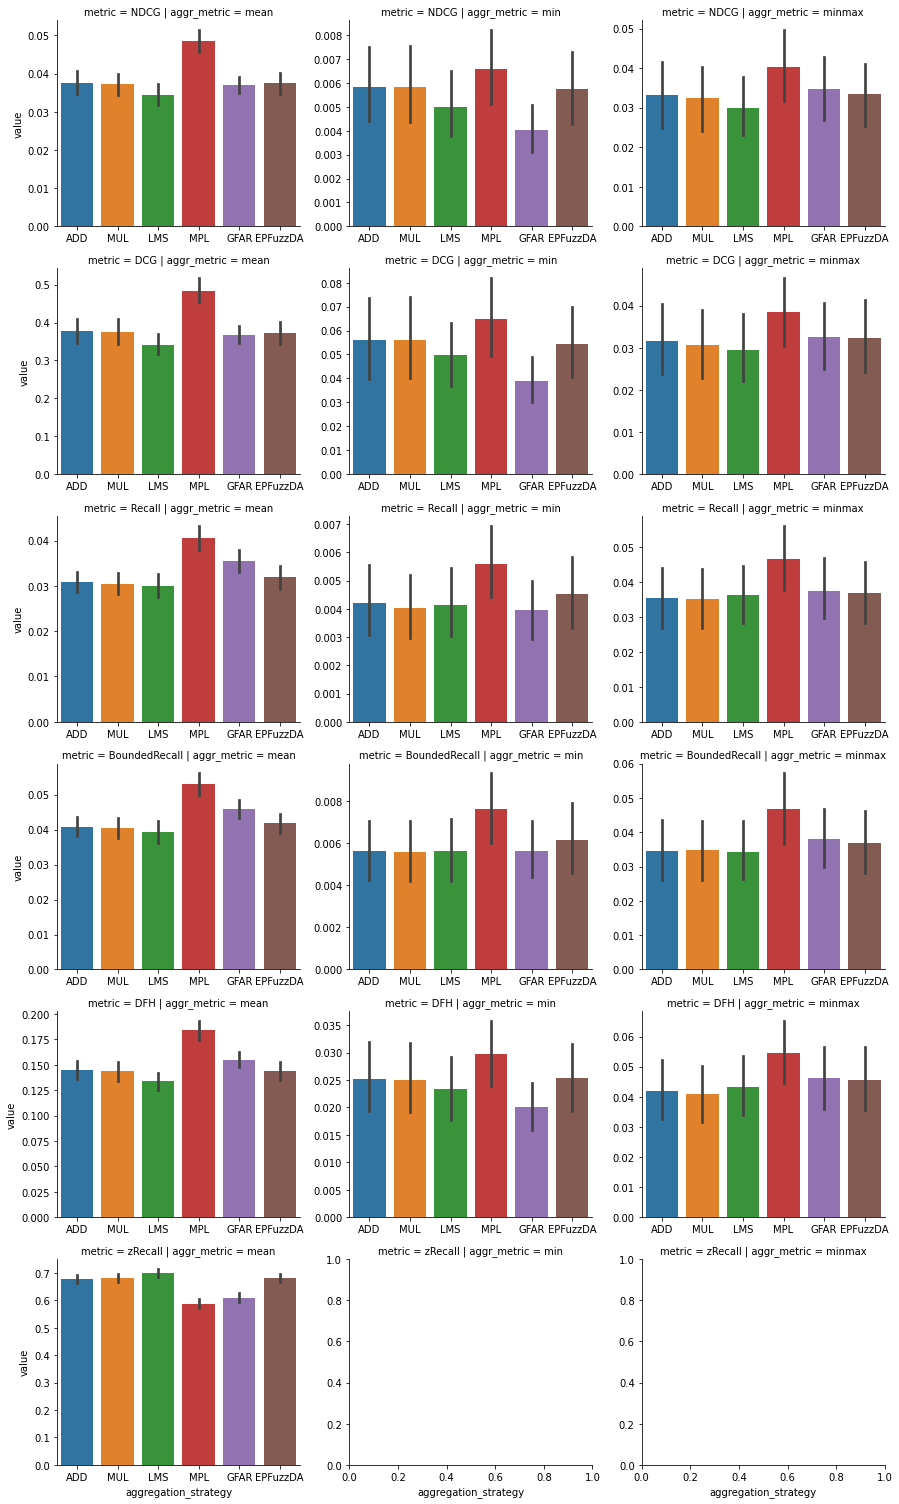

In [134]:
# depict overall (mean) results across all groups

all_group_res = eval_df.groupby(['metric', 'aggr_metric', 'aggregation_strategy']).mean().reset_index()

g = sns.catplot(data=eval_df, row="metric", col="aggr_metric", 
                   x="aggregation_strategy", y="value", sharex=False, sharey=False,
                   kind="bar",  height=3.5, aspect=1.2)

In [135]:
group_composition_DF = pd.DataFrame(group_composition).T
eval_df_with_group_info = group_composition_DF.join(eval_df.set_index("group_id"))
eval_df_with_group_info.head()

,group_size,group_similarity,group_members,metric,aggr_metric,value,aggregation_strategy,current_fold
0,2,random,"[4805, 5428]",NDCG,mean,0.019192,ADD,0
0,2,random,"[4805, 5428]",NDCG,min,0.000000,ADD,0
0,2,random,"[4805, 5428]",NDCG,minmax,0.000000,ADD,0
0,2,random,"[4805, 5428]",DCG,mean,0.270238,ADD,0
0,2,random,"[4805, 5428]",DCG,min,0.000000,ADD,0


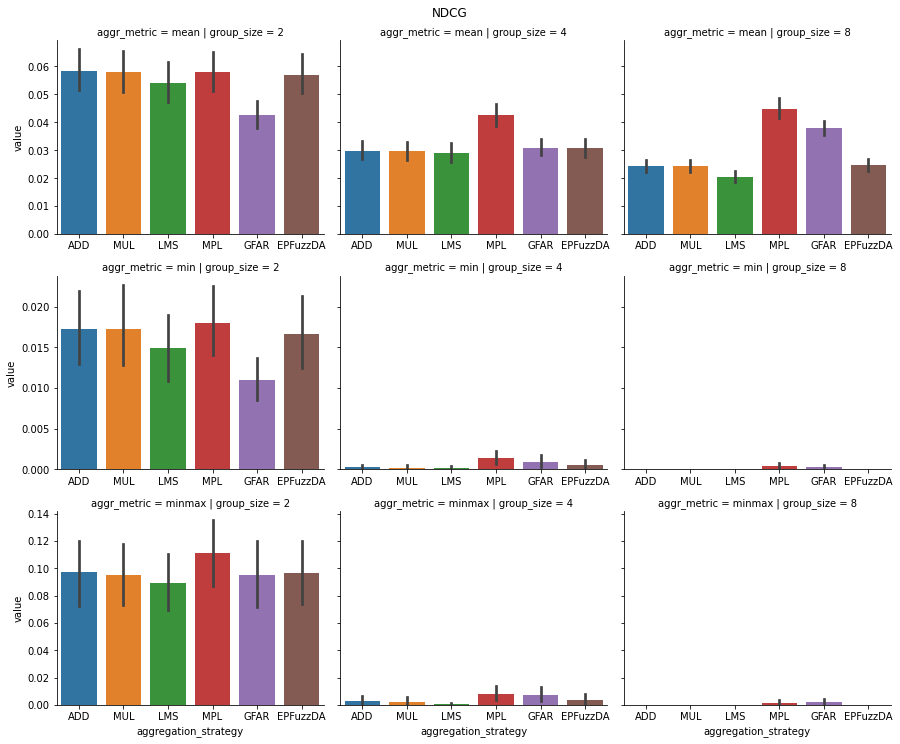

In [136]:
# metric variance per group size; keeping the aggregation strategies visible
metric = "NDCG"
g = sns.catplot(data=eval_df_with_group_info.loc[eval_df_with_group_info.metric==metric], col="group_size", row="aggr_metric", 
                   x="aggregation_strategy", y="value", sharex=False, sharey="row",
                   kind="bar",  height=3.5, aspect=1.2)
plt.suptitle(metric)
plt.tight_layout()


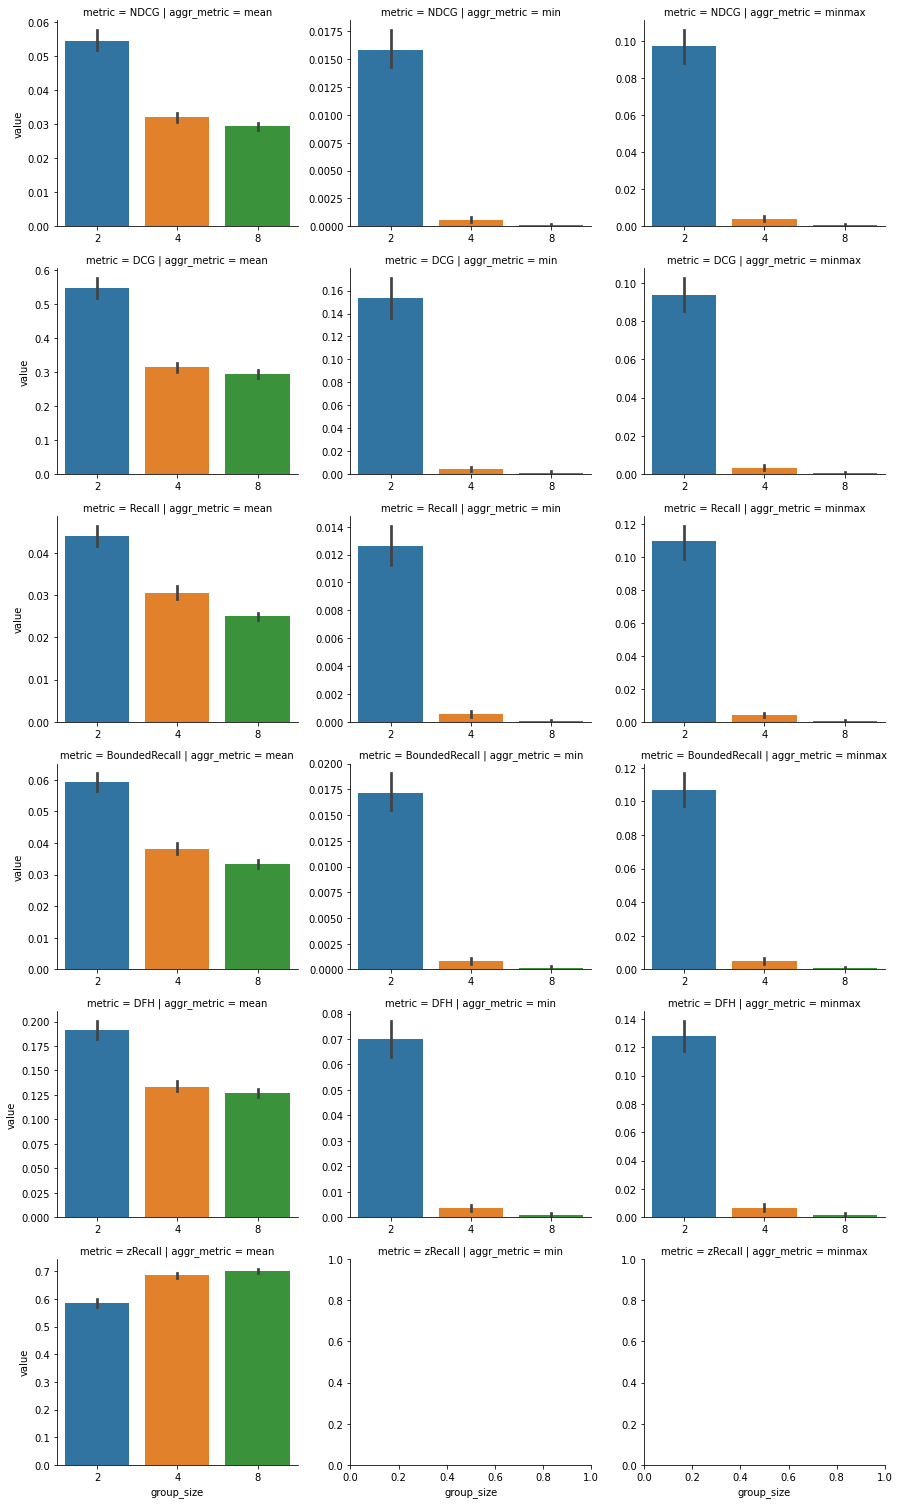

In [137]:
# metric variance per group size; merging all aggregation strategies
g = sns.catplot(data=eval_df_with_group_info, row="metric", col="aggr_metric", 
                   x="group_size", y="value", sharex=False, sharey=False,
                   kind="bar",  height=3.5, aspect=1.2)


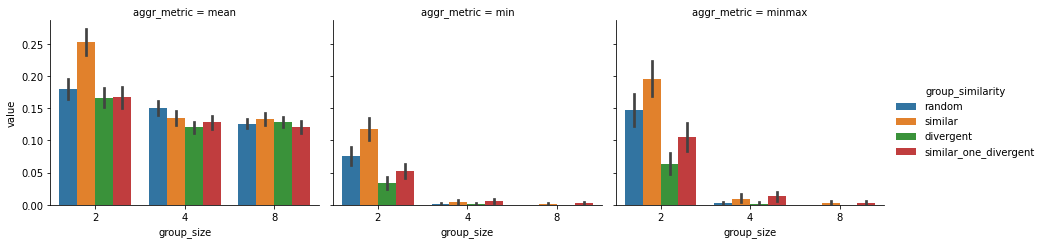

In [140]:
# metric variance per group size and group type; merging all aggregation strategies
metric = "DFH"
g = sns.catplot(data=eval_df_with_group_info.loc[eval_df_with_group_info.metric==metric], hue="group_similarity", col="aggr_metric", 
                   x="group_size", y="value", sharex=False, sharey="row",
                   kind="bar",  height=3.5, aspect=1.2)

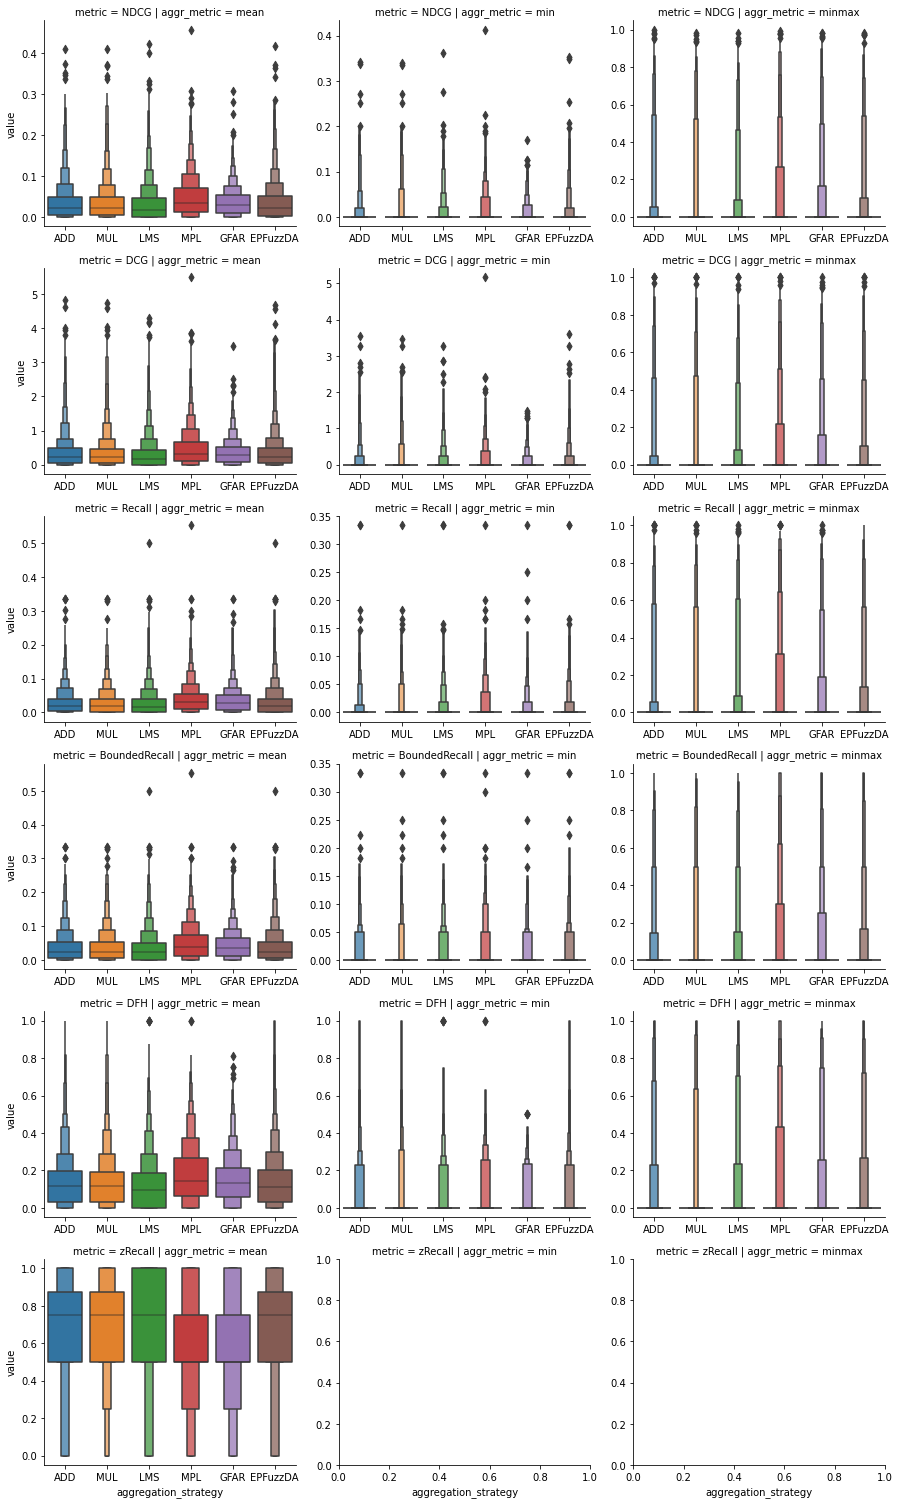

In [139]:
# depict distribution of per-group values for all metrics
g = sns.catplot(data=eval_df, row="metric", col="aggr_metric", 
                   x="aggregation_strategy", y="value", sharex=False, sharey=False,
                   kind="boxen",  height=3.5, aspect=1.2)

In [17]:
group_folds = eval_df.groupby(['metric', 'aggr_metric', 'aggregation_strategy', 'group_id']).mean()

In [18]:
display(group_folds['value'].reset_index().sort_values(by='group_id'))

,metric,aggr_metric,aggregation_strategy,group_id,value
0,BoundedRecall,mean,ADD,0,0.050000
420,BoundedRecall,min,EPFuzzDA,0,0.010000
4140,NDCG,minmax,LMS,0,0.084711
4080,NDCG,minmax,GFAR,0,0.143581
4020,NDCG,minmax,EPFuzzDA,0,0.090338
...,...,...,...,...,...
3959,NDCG,min,MUL,59,0.000000
4019,NDCG,minmax,ADD,59,0.000000
4079,NDCG,minmax,EPFuzzDA,59,0.000000
3539,NDCG,mean,MPL,59,0.051309


In [19]:
eval_df.groupby(['metric', 'aggr_metric', 'aggregation_strategy']).mean().head(50)

value  group_id  \
metric        aggr_metric aggregation_strategy                       
BoundedRecall mean        ADD                   0.043101      29.5   
                          EPFuzzDA              0.045542      29.5   
                          GFAR                  0.046051      29.5   
                          LMS                   0.042213      29.5   
                          MPL                   0.049808      29.5   
                          MUL                   0.041836      29.5   
              min         ADD                   0.006982      29.5   
                          EPFuzzDA              0.008646      29.5   
                          GFAR                  0.005493      29.5   
                          LMS                   0.007659      29.5   
                          MPL                   0.005978      29.5   
                          MUL                   0.006888      29.5   
              minmax      ADD                   0.038519      29.5   
                          EPFuzzDA              0.041869      29.5   
                          GFAR                  0.032282      29.5   
                          LMS                   0.035364      29.5   
                          MPL                   0.038897      29.5   
                          MUL                   0.039357      29.5   
DCG           mean        ADD                   1.721625      29.5   
                          EPFuzzDA              1.727746      29.5   
                          GFAR                  1.603163      29.5   
                          LMS                   1.598030      29.5   
                          MPL                   1.832524      29.5   
                          MUL                   1.713527      29.5   
              min         ADD                   0.296986      29.5   
                          EPFuzzDA              0.292900      29.5   
                          GFAR                  0.174827      29.5   
                          LMS                   0.268586      29.5   
                          MPL                   0.290005      29.5   
                          MUL                   0.308490      29.5   
              minmax      ADD                   0.048318      29.5   
                          EPFuzzDA              0.043264      29.5   
                          GFAR                  0.038154      29.5   
                          LMS                   0.040477      29.5   
                          MPL                   0.052305      29.5   
                          MUL                   0.046739      29.5   
DFH           mean        ADD                   0.153801      29.5   
                          EPFuzzDA              0.151365      29.5   
                          GFAR                  0.154614      29.5   
                          LMS                   0.139362      29.5   
                          MPL                   0.161513      29.5   
                          MUL                   0.152498      29.5   
              min         ADD                   0.028913      29.5   
                          EPFuzzDA              0.026015      29.5   
                          GFAR                  0.019690      29.5   
                          LMS                   0.022990      29.5   
                          MPL                   0.027370      29.5   
                          MUL                   0.028152      29.5   
              minmax      ADD                   0.050484      29.5   
                          EPFuzzDA              0.049615      29.5   

                                                current_fold  
metric        aggr_metric aggregation_strategy                
BoundedRecall mean        ADD                            2.0  
                          EPFuzzDA                       2.0  
                          GFAR                           2.0  
                          LMS                            2.0  
                          MPL   